In [1]:
import pandas as pd
import numpy as np
import pickle

In [2]:
x_train_list = pickle.load(open('../gen_data/x_train--features2.ipynb--.pickle','rb'))
x_test_list = pickle.load(open('../gen_data/x_test--features2.ipynb--.pickle','rb'))

sales = pd.read_csv('../gen_data/train1.csv')

### Generate time specific market price data

In [3]:
mean_price = sales.groupby(['date_block_num','item_id'],as_index=True).item_price.mean()
std_price = sales.groupby(['date_block_num','item_id'],as_index=True).item_price.std(ddof=1)
median_price = sales.groupby(['date_block_num','item_id'],as_index=True).item_price.median()

price_data = pd.concat([mean_price,std_price,median_price],axis=1)
price_data.columns = ['mean_prevmonth_item_price','std_prevmonth_item_price','median_prevmonth_item_price']
price_data.reset_index(inplace=True)
price_data['date_block_num'] += 1

### Generate shop-time price data

In [4]:
#not gonna worry about getting median price by transaction, will 
#settle for median price by row (which could incnlude many transactions)
shop_item_data = sales.groupby(['date_block_num','shop_id','item_id'],as_index=False).item_price.median()
shop_item_data['date_block_num'] += 1
shop_item_data.columns = ['date_block_num','shop_id','item_id','median_prevmonth_shop_item_price']
shop_item_data.head()

,date_block_num,shop_id,item_id,median_prevmonth_shop_item_price
0,1,2,27,2499.0
1,1,2,33,499.0
2,1,2,317,299.0
3,1,2,438,299.0
4,1,2,471,399.0


In [5]:
#function to downcast data types to 32 bits
def downcast(df):
    float_cols = [col for col in df if df[col].dtype=='float64']
    int_cols = [col for col in df if df[col].dtype=='int64']

    df[float_cols] = df[float_cols].astype(np.float32)
    df[int_cols] = df[int_cols].astype(np.int32)
    
    return(df)

In [6]:
price_data = downcast(price_data)

In [7]:
def merge_price_data(df):
    return df.merge(price_data,how='left').merge(shop_item_data,how='left')

In [8]:
x_train_list = list(map(merge_price_data,x_train_list))
x_test_list = list(map(merge_price_data,x_test_list))

In [9]:
def add_prop_median(df):
    df['prop_median_item_price'] = df.median_prevmonth_shop_item_price/df.median_prevmonth_item_price
    return df

In [10]:
x_train_list = list(map(add_prop_median,x_train_list))
x_test_list = list(map(add_prop_median,x_test_list))

### consider deleting

In [11]:
#def insert_sd_above_market(df):
#    df['std_above_market'] = (df.mean_prevmonth_shop_item_price - df.mean_prevmonth_item_price) / df.std_prevmonth_item_price
#    return df

In [12]:
#def cleanup(df):
#    mean_sd = np.nanmean(df.std_prevmonth_item_price)
#    df['std_prevmonth_item_price'] = df.std_prevmonth_item_price.fillna(mean_sd)
#    df['std_above_market'] = df.std_above_market.fillna(0)
#    return df

In [13]:
#x_train_list = list(map(insert_sd_above_market,x_train_list))
#x_test_list = list(map(insert_sd_above_market,x_test_list))

In [14]:
#x_train_list = list(map(cleanup,x_train_list))
#x_test_list = list(map(cleanup,x_test_list))

### end consider deleting

### Save

In [15]:
pickle.dump(x_train_list,open('../gen_data/x_train--features3.ipynb--.pickle','wb'))
pickle.dump(x_test_list,open('../gen_data/x_test--features3.ipynb--.pickle','wb'))

In [16]:
x_train_list[1][x_train_list[1].item_id!=7019].prop_median_item_price.plot(kind='hist')

In [17]:
x_train_list[1].loc[2361416]

date_block_num                             19
shop_id                                     6
item_id                                  7019
item_category_id                           23
first_sale_date_block                      15
new_item                                    0
city                                 Воронеж 
item_type                               Игры 
item_info                            XBOX 360
prop_median_item_price                   5198
sum_item_sales_back_1                      64
sum_shop_sales_back_1                    2543
item_cnt_month_back_1                       1
sum_item_cat_sales_back_1                4460
sum_item_cat_shop_sales_back_1             88
sum_city_back_1                          4266
sum_itemtype_back_1                     15955
sum_iteminfo_back_1                      5230
sum_city_item_back_1                        2
sum_city_item_cat_back_1                  244
sum_itemtype_shop_back_1                  403
sum_itemtype_city_back_1          

### clearly many 0.5 item prices are throwing this

In [18]:
x_train_list[1].sort_values('prop_median_item_price',ascending=False)[['date_block_num','shop_id','item_id','median_prevmonth_item_price','median_prevmonth_shop_item_price','prop_median_item_price']]

,date_block_num,shop_id,item_id,median_prevmonth_item_price,median_prevmonth_shop_item_price,prop_median_item_price
2361416,19,6,7019,0.50,2599.0,5198.0
2431409,19,21,7019,0.50,2599.0,5198.0
2548365,19,42,1851,0.50,2499.0,4998.0
2376564,19,11,1851,0.50,2001.0,4002.0
2603014,19,51,1856,0.50,2001.0,4002.0
2603016,19,51,1858,0.50,2001.0,4002.0
2373946,19,11,1856,0.50,2001.0,4002.0
2514056,19,37,5241,0.50,1999.0,3998.0
2342257,19,3,5243,0.50,1999.0,3998.0
2615864,19,53,5241,0.50,1999.0,3998.0


In [19]:
x_train_list[1].median_prevmonth_item_price.clip(0,1)

0          1.00
1          1.00
2          1.00
3          1.00
4          1.00
5          1.00
6          1.00
7          1.00
8          1.00
9          1.00
10         1.00
11         1.00
12         1.00
13          NaN
14         1.00
15         1.00
16         1.00
17         1.00
18         1.00
19         1.00
20         1.00
21          NaN
22         1.00
23         1.00
24         1.00
25         1.00
26         1.00
27         1.00
28         1.00
29         1.00
           ... 
6425064    1.00
6425065    1.00
6425066    1.00
6425067    1.00
6425068     NaN
6425069    1.00
6425070    1.00
6425071     NaN
6425072    1.00
6425073    1.00
6425074    1.00
6425075    1.00
6425076    1.00
6425077    1.00
6425078     NaN
6425079    1.00
6425080    1.00
6425081    0.99
6425082    0.99
6425083     NaN
6425084    1.00
6425085     NaN
6425086    1.00
6425087    1.00
6425088    1.00
6425089    1.00
6425090     NaN
6425091    1.00
6425092    1.00
6425093    1.00
Name: median_prevmonth_i

In [20]:
np.log(1)

0.0

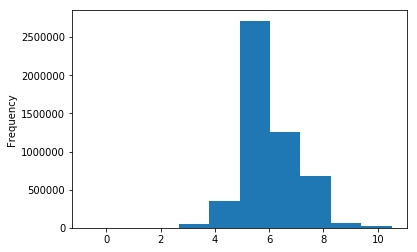

In [21]:
s = np.log(x_train_list[1].median_prevmonth_item_price)
s.plot(kind='hist')

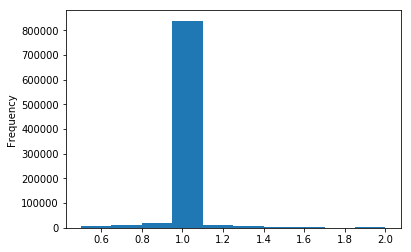

In [22]:
x_train_list[1].prop_median_item_price.clip(0.5,2).plot(kind='hist')
#s.plot(kind='hist')

In [23]:
#x_train_list[1].sort_values('prop_median_item_price')[['date_block_num','shop_id','item_id','median_prevmonth_item_price','median_prevmonth_shop_item_price','prop_median_item_price']]

In [24]:
#there are some items with wild "variance" in price, (not mathematical variance)
int_items = [1856,1858,1851,5241,5243]
x_train_list[1][x_train_list[1].item_id.isin(int_items)].


SyntaxError: invalid syntax (<ipython-input-24-5cc6ad2ed7f5>, line 3)

### titanfall is getting sold for 0.5 rubels a lot in month 18 for some reason

In [ ]:
#shop 6
#sales[(sales.item_id==7019)].groupby('shop_id').item_price.mean()#[['shop_id','item_price']]
sales[(sales.date_block_num==15)&(sales.item_id==7019)][['date_block_num','shop_id','item_price']]
